# BIOSIGNAL PROCESSING AND ANALYSIS PROJECT


In [26]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = 'datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

print(X_train,y_train)
print(np.array(X_train).shape)

[[[-1.190e-01 -5.500e-02  6.400e-02 ... -2.600e-02 -3.900e-02 -7.900e-02]
  [-1.160e-01 -5.100e-02  6.500e-02 ... -3.100e-02 -3.400e-02 -7.400e-02]
  [-1.200e-01 -4.400e-02  7.600e-02 ... -2.800e-02 -2.900e-02 -6.900e-02]
  ...
  [ 6.900e-02  0.000e+00 -6.900e-02 ...  2.400e-02 -4.100e-02 -5.800e-02]
  [ 8.600e-02  4.000e-03 -8.100e-02 ...  2.420e-01 -4.600e-02 -9.800e-02]
  [ 2.200e-02 -3.100e-02 -5.400e-02 ...  1.430e-01 -3.500e-02 -1.200e-01]]

 [[ 4.000e-03  1.380e-01  1.340e-01 ...  1.920e-01  8.300e-02  8.800e-02]
  [-2.000e-02  1.160e-01  1.360e-01 ...  1.560e-01  5.700e-02  6.300e-02]
  [-5.300e-02  9.200e-02  1.450e-01 ...  1.070e-01  1.300e-02  2.200e-02]
  ...
  [ 1.210e-01  3.980e-01  2.770e-01 ... -1.065e+00 -4.920e-01 -1.560e-01]
  [-3.260e-01  5.700e-02  3.830e-01 ... -2.800e-01 -1.750e-01 -7.100e-02]
  [-3.480e-01 -5.600e-02  2.920e-01 ... -3.080e-01 -2.310e-01 -1.450e-01]]

 [[-2.900e-02 -7.900e-02 -4.900e-02 ... -1.030e-01 -7.600e-02 -6.600e-02]
  [-3.500e-02 -7.000e-

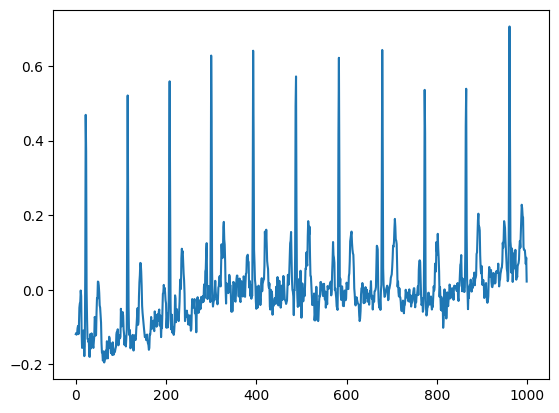

In [27]:
import matplotlib.pyplot as plt
# plot the first 2 signals
plt.plot(X_train[0, :, 0])
plt.show()

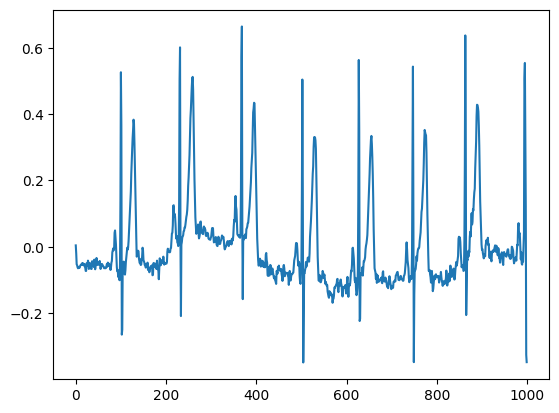

In [28]:
plt.plot(X_train[1, :, 0])
plt.show()

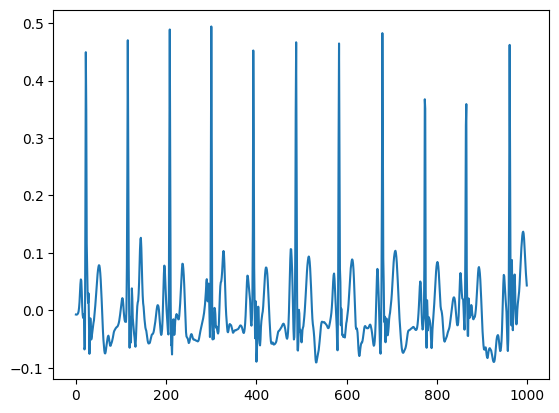

In [29]:
import pywt
import numpy as np
from scipy.signal import butter, filtfilt

def high_pass_filter(signal, cutoff=0.5, fs=100, order=5):
    # Normalizing the frequency
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def denoise_ecg(ecg_signal, wavelet='db6', level=4, fs=100):
    # First, apply high-pass filter to remove baseline wander
    ecg_signal = high_pass_filter(ecg_signal, cutoff=0.5, fs=fs)  # Adjust cutoff and fs as needed

    # Perform Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)

    # Threshold for denoising (universal threshold)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal)))

    # Apply threshold to detail coefficients
    denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]

    # Reconstruct the signal from denoised coefficients
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)

    return denoised_signal

ecg_signal = X_train[0, :, 0]
denoised_ecg = denoise_ecg(ecg_signal)

# Plotting the denoised signal
plt.plot(denoised_ecg)
plt.show()


In [30]:
import numpy as np
import pywt
from scipy.signal import butter, filtfilt
from tqdm import tqdm

def high_pass_filter(signal, cutoff=0.5, fs=100, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def denoise_ecg(ecg_signal, wavelet='db6', level=4):
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal)))
    denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal

def process_ecg_dataset(dataset, fs=100):
    # dataset shape should be (samples, time, channels)
    num_samples, _, num_channels = dataset.shape
    denoised_dataset = np.empty_like(dataset)

    for i in tqdm(range(num_samples), desc='Denoising ECG Samples'):
        for j in range(num_channels):
            # Extract the signal for each channel
            signal = dataset[i, :, j]
            # Remove baseline wander
            filtered_signal = high_pass_filter(signal, cutoff=0.5, fs=fs)
            # Denoise the signal
            denoised_signal = denoise_ecg(filtered_signal)
            # Store the denoised signal
            denoised_dataset[i, :, j] = denoised_signal

    return denoised_dataset

ecg_data = X_train
denoised_data = process_ecg_dataset(ecg_data)
print(denoised_data.shape)


Denoising ECG Samples:  57%|███████████████████████████████████████████████████████████████▊                                               | 11262/19601 [01:00<00:43, 189.58it/s]/home/cs20b1057/miniconda3/envs/srav_misc/lib/python3.9/site-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)
Denoising ECG Samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19601/19601 [01:46<00:00, 184.25it/s]

(19601, 1000, 12)


In [31]:
# denoising the test data as well
denoised_test_data = process_ecg_dataset(X_test)
print(denoised_test_data.shape)

Denoising ECG Samples: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2198/2198 [00:12<00:00, 179.72it/s]

(2198, 1000, 12)


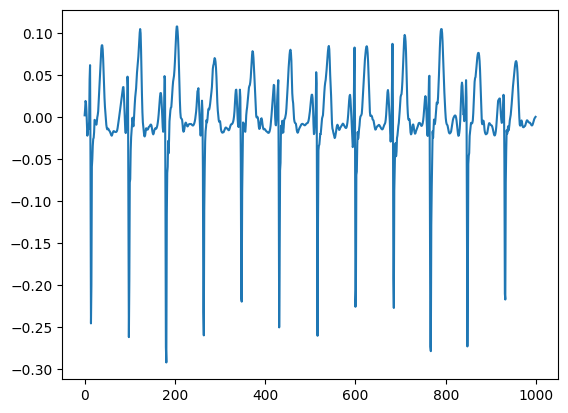

In [12]:
# plotting the first signal of the denoised data
plt.plot(denoised_data[0, :, 0])
plt.show()

In [33]:
# removing all the NaN values from the data and replacing them with 0
denoised_data = np.nan_to_num(denoised_data)
print(denoised_data.shape)

(19601, 1000, 12)


In [35]:
# putting the denoised data in x_train and x_test
X_train = denoised_data
X_test = denoised_test_data

In [36]:
# putting the first lead ecg data into a variable called 1st_lead_ecg_train
first_lead_ecg_train = X_train[:, :, 0]
print(first_lead_ecg_train.shape)

(19601, 1000)


In [37]:
# putting the remaining lead ecg data into a variable called remaining_lead_ecg_train
remaining_lead_ecg_train = X_train[:, :, 1:]
print(remaining_lead_ecg_train.shape)

(19601, 1000, 11)


In [38]:
# putting the first lead ecg data into a variable called 1st_lead_ecg_test
first_lead_ecg_test = X_test[:, :, 0]
print(first_lead_ecg_test.shape)

(2198, 1000)


In [39]:
# putting the remaining lead ecg data into a variable called remaining_lead_ecg_test
remaining_lead_ecg_test = X_test[:, :, 1:]
print(remaining_lead_ecg_test.shape)

(2198, 1000, 11)


Now with the data in the right shape, we can start building the model. We will start by building a model that uses only the first lead ECG data, that can predict the remaining lead ECG data. We will use a simple LSTM model for this task.

In [40]:
# Importing the necessary libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [41]:
input_shape = (1000,1)

In [42]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [43]:
# tf.debugging.set_log_device_placement(True)
#
# try:
#   # Specify an invalid GPU device
#   with tf.device('GPU:1'):
#     # Building the model
#     model = Sequential()
#     model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
#     model.add(Dense(units = 11, activation='linear'))
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
#     model.summary()
#     # Training the model
#     history = model.fit(first_lead_ecg_train.reshape(-1,1000,1), remaining_lead_ecg_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])
# except RuntimeError as e:
#   print(e)


In [44]:
# Building the model
model = Sequential()
model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
model.add(Dense(units = 11, activation='linear'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1000, 64)          16896     
                                                                 
 dense_1 (Dense)             (None, 1000, 11)          715       
                                                                 
Total params: 17,611
Trainable params: 17,611
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Training the model
history = model.fit(first_lead_ecg_train.reshape(-1,1000,1), remaining_lead_ecg_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])

Epoch 1/100
490/490 [==============================] - 20s 40ms/step - loss: 0.0310 - val_loss: 0.0287
Epoch 2/100
490/490 [==============================] - 20s 41ms/step - loss: 0.0259 - val_loss: 0.0271
Epoch 3/100
490/490 [==============================] - 19s 38ms/step - loss: 0.0243 - val_loss: 0.0261
Epoch 4/100
490/490 [==============================] - 19s 38ms/step - loss: 0.0237 - val_loss: 0.0255
Epoch 5/100
490/490 [==============================] - 19s 38ms/step - loss: 0.0232 - val_loss: 0.0252
Epoch 6/100
490/490 [==============================] - 20s 40ms/step - loss: 0.0229 - val_loss: 0.0247
Epoch 7/100
490/490 [==============================] - 20s 40ms/step - loss: 0.0225 - val_loss: 0.0243
Epoch 8/100
490/490 [==============================] - 19s 38ms/step - loss: 0.0225 - val_loss: 0.0249
Epoch 9/100
490/490 [==============================] - 20s 41ms/step - loss: 0.0224 - val_loss: 0.0244
Epoch 10/100
490/490 [==============================] - 19s 38ms/step - l

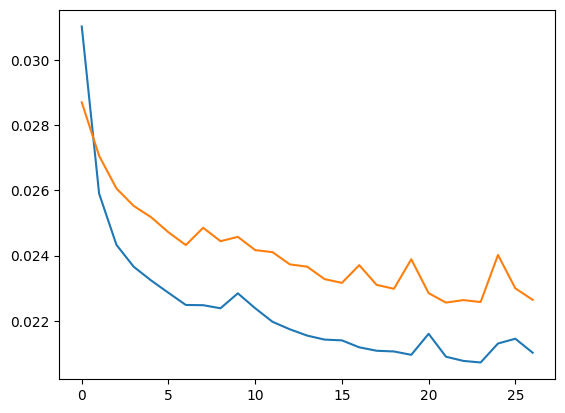

In [46]:
# plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
# # Making predictions
# with tf.device('GPU:1'):
#     predictions = model.predict(first_lead_ecg_test.reshape(-1,1000,1))
#     print(predictions.shape)

In [47]:
# Making predictions
predictions = model.predict(first_lead_ecg_test.reshape(-1,1000,1))
print(predictions.shape)

69/69 [==============================] - 2s 20ms/step
(2198, 1000, 11)


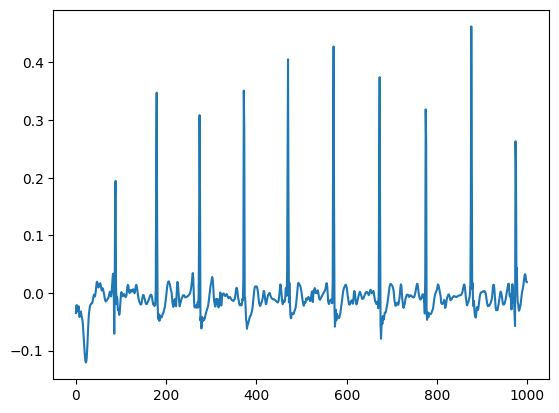

In [48]:
# plotting the prediction
plt.plot(predictions[0,:,1])
plt.show()

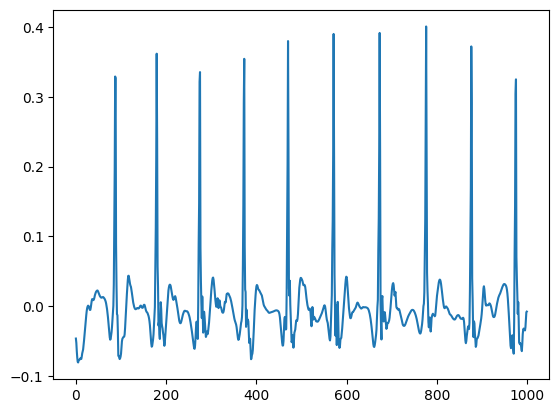

In [49]:
plt.plot(remaining_lead_ecg_test[0,:,1])
plt.show()

In [50]:
# evaluating the predictions using correlation and mean squared error

In [51]:
! pip install scikit-learn

/bin/bash: /home/cs20b1057/miniconda3/envs/srav_misc/lib/libtinfo.so.6: no version information available (required by /bin/bash)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 3.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 2.4 MB/s eta 0:00:0000:01:00:01


In [52]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

In [53]:
# calculating the mean squared error
mse = mean_squared_error(remaining_lead_ecg_test.reshape(-1,1000), predictions.reshape(-1,1000))
print(mse)
# calculating rmse as the square root of mse
rmse = np.sqrt(mse)
print(rmse)

0.02034823720816719
0.1426472474608858


In [54]:
# calculating r2 score
from sklearn.metrics import r2_score
r2 = r2_score(remaining_lead_ecg_test.reshape(-1,1000), predictions.reshape(-1,1000))
print(r2)

0.530038566862096


In [55]:
import numpy as np
from scipy.stats import pearsonr

# # Assuming you have your test data and labels
# X_test_reshaped = X_test.reshape(-1, 1000, 1)  # Reshape the test data if needed
# predictions = model.predict(X_test_reshaped)  # Get predictions for the test data

# Calculate Pearson correlation coefficient for each lead
correlations = []
for i in range(11):  # Assuming you have 11 leads
    actual = remaining_lead_ecg_test[:, :, i].flatten()  # Flatten the actual labels for the ith lead
    predicted = predictions[:, :, i].flatten()  # Flatten the predictions for the ith lead
    corr, _ = pearsonr(actual, predicted)  # Calculate Pearson correlation coefficient
    correlations.append(corr)

# Print the correlation coefficients for each lead
for i, corr in enumerate(correlations):
    print(f"Pearson correlation coefficient for lead {i+1}: {corr}")

Pearson correlation coefficient for lead 1: 0.6683058657918346
Pearson correlation coefficient for lead 2: 0.666726684978783
Pearson correlation coefficient for lead 3: 0.8969183888994103
Pearson correlation coefficient for lead 4: 0.8960434262282885
Pearson correlation coefficient for lead 5: 0.5199899270732048
Pearson correlation coefficient for lead 6: 0.7998061898835694
Pearson correlation coefficient for lead 7: 0.7211119381423753
Pearson correlation coefficient for lead 8: 0.6709872999414785
Pearson correlation coefficient for lead 9: 0.7003886123244856
Pearson correlation coefficient for lead 10: 0.7700857568568044
Pearson correlation coefficient for lead 11: 0.7781102352810059


Using a different model to see if the performance improves

In [56]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# tf.debugging.set_log_device_placement(True)
#
# try:
#   # Specify an invalid GPU device
#   with tf.device('GPU:1'):
#     # using a different model
#     model = Sequential()
#     model.add(LSTM(units=128, input_shape=input_shape, return_sequences=True))
#     model.add(Dropout(0.2))  # Adding dropout regularization
#     model.add(LSTM(units=64, return_sequences=True))
#     model.add(Dropout(0.2))  # Adding dropout regularization
#     model.add(Dense(units=32, activation='relu'))  # Adding a dense layer
#     model.add(Dense(units=11, activation='linear'))  # Output layer with 11 neurons for 11 leads
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
#     # Training the model
#     history = model.fit(first_lead_ecg_train.reshape(-1,1000,1), remaining_lead_ecg_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])
# except RuntimeError as e:
#   print(e)


In [59]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [60]:
# Training the model
history = model.fit(first_lead_ecg_train.reshape(-1,1000,1), remaining_lead_ecg_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])

Epoch 1/30
490/490 [==============================] - 50s 98ms/step - loss: 0.0284 - val_loss: 0.0260
Epoch 2/30
490/490 [==============================] - 47s 96ms/step - loss: 0.0238 - val_loss: 0.0249
Epoch 3/30
490/490 [==============================] - 47s 96ms/step - loss: 0.0229 - val_loss: 0.0243
Epoch 4/30
490/490 [==============================] - 47s 96ms/step - loss: 0.0224 - val_loss: 0.0237
Epoch 5/30
490/490 [==============================] - 47s 96ms/step - loss: 0.0222 - val_loss: 0.0235
Epoch 6/30
490/490 [==============================] - 47s 97ms/step - loss: 0.0219 - val_loss: 0.0231
Epoch 7/30
490/490 [==============================] - 47s 96ms/step - loss: 0.0217 - val_loss: 0.0232
Epoch 8/30
490/490 [==============================] - 47s 96ms/step - loss: 0.0215 - val_loss: 0.0230
Epoch 9/30
490/490 [==============================] - 47s 96ms/step - loss: 0.0213 - val_loss: 0.0225
Epoch 10/30
490/490 [==============================] - 47s 96ms/step - loss: 0.021

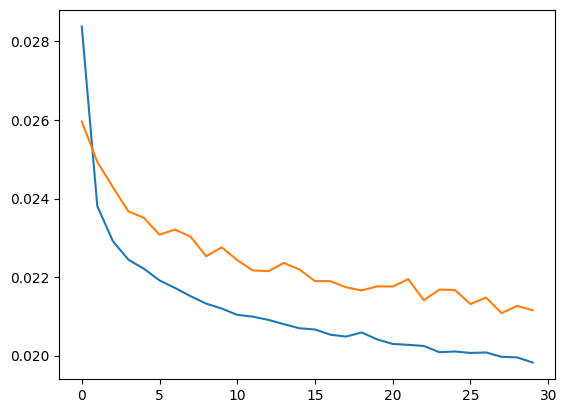

In [61]:
# plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [62]:
# tf.debugging.set_log_device_placement(True)
#
# try:
#   # Specify an invalid GPU device
#   with tf.device('GPU:1'):
#     # Making predictions
#     predictions = model.predict(first_lead_ecg_test.reshape(-1,1000,1))
#     print(predictions.shape)
# except RuntimeError as e:
#   print(e)


69/69 [==============================] - 3s 33ms/step
(2198, 1000, 11)


In [62]:
# Making predictions
predictions = model.predict(first_lead_ecg_test.reshape(-1,1000,1))
print(predictions.shape)

69/69 [==============================] - 4s 38ms/step
(2198, 1000, 11)


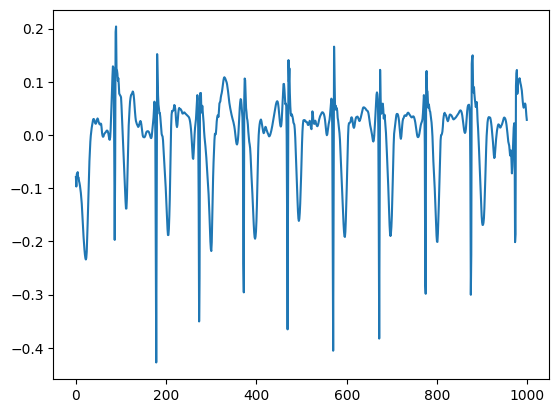

In [70]:
# plotting a prediction
plt.plot(predictions[0,:,2])
plt.show()

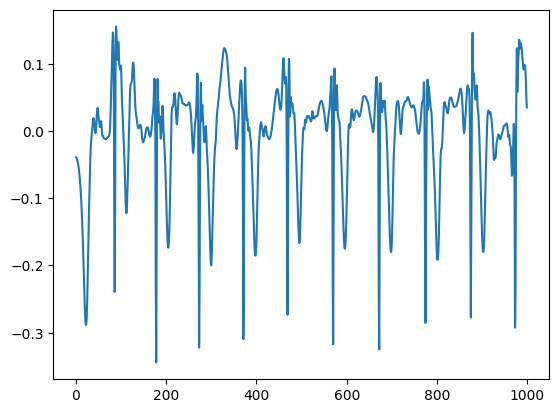

In [71]:
plt.plot(remaining_lead_ecg_test[0,:,2])
plt.show()

In [65]:
# calculating the mean squared error
mse = mean_squared_error(remaining_lead_ecg_test.reshape(-1,1000), predictions.reshape(-1,1000))
print(mse)
# calculating rmse as the square root of mse
rmse = np.sqrt(mse)
print(rmse)

0.01962266758309634
0.14008093226094814


In [66]:
# calculating r2 score
from sklearn.metrics import r2_score
r2 = r2_score(remaining_lead_ecg_test.reshape(-1,1000), predictions.reshape(-1,1000))
print(r2)

0.5466595148349074


In [67]:
import numpy as np
from scipy.stats import pearsonr

# # Assuming you have your test data and labels
# X_test_reshaped = X_test.reshape(-1, 1000, 1)  # Reshape the test data if needed
# predictions = model.predict(X_test_reshaped)  # Get predictions for the test data

# Calculate Pearson correlation coefficient for each lead
correlations = []
for i in range(11):  # Assuming you have 11 leads
    actual = remaining_lead_ecg_test[:, :, i].flatten()  # Flatten the actual labels for the ith lead
    predicted = predictions[:, :, i].flatten()  # Flatten the predictions for the ith lead
    corr, _ = pearsonr(actual, predicted)  # Calculate Pearson correlation coefficient
    correlations.append(corr)

# Print the correlation coefficients for each lead
for i, corr in enumerate(correlations):
    print(f"Pearson correlation coefficient for lead {i+1}: {corr}")

Pearson correlation coefficient for lead 1: 0.6824202931071122
Pearson correlation coefficient for lead 2: 0.6787739471579738
Pearson correlation coefficient for lead 3: 0.8998429641765593
Pearson correlation coefficient for lead 4: 0.8956748555541125
Pearson correlation coefficient for lead 5: 0.5440337721885327
Pearson correlation coefficient for lead 6: 0.8088863708811175
Pearson correlation coefficient for lead 7: 0.7358327705665082
Pearson correlation coefficient for lead 8: 0.6834751083763443
Pearson correlation coefficient for lead 9: 0.7158174973972259
Pearson correlation coefficient for lead 10: 0.7802172646835527
Pearson correlation coefficient for lead 11: 0.7846247123217898


In [68]:
# getting r2 score for every lead as well
r2_scores = []
for i in range(11):
    r2 = r2_score(remaining_lead_ecg_test[:, :, i].flatten(), predictions[:, :, i].flatten())
    r2_scores.append(r2)

In [69]:
# printing the r2 scores for each lead
for i, r2 in enumerate(r2_scores):
    print(f"R2 score for lead {i+1}: {r2}")

R2 score for lead 1: 0.46562619870483046
R2 score for lead 2: 0.45711605147139045
R2 score for lead 3: 0.809012757647732
R2 score for lead 4: 0.8014354827036391
R2 score for lead 5: 0.2941087882742782
R2 score for lead 6: 0.6525485122331413
R2 score for lead 7: 0.5406534802910007
R2 score for lead 8: 0.4663153601868013
R2 score for lead 9: 0.511825956006076
R2 score for lead 10: 0.6084684339784981
R2 score for lead 11: 0.6146274202218384
